## Import Necessary Dependencies

In [31]:
#Import libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.util import ngrams

import string
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import gensim
from gensim.models import Word2Vec

from wordcloud import WordCloud, STOPWORDS

np.random.seed(0)

%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/Filip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Filip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read and Load the Dataset

In [2]:
# Upload datasets
df = pd.read_csv('tweet_product_company.csv', encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
df.columns = ['tweet_text', 'product', 'label']
df.head()

,tweet_text,product,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
for column in df.columns[1:]:
    print('Column: ', column)
    print('Unique values count:', len(df[column].unique()))
    print('Values: ', df[column].unique())
    print('----------------')

Column:  product
Unique values count: 10
Values:  ['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']
----------------
Column:  label
Unique values count: 4
Values:  ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
----------------


Combine labels "I can't tell" and 'No emotion toward brand or product' to one category "Neutral emotion"

In [6]:
df['label'][df['label'] == "I can't tell"] = 'Neutral emotion'
df['label'][df['label'] == 'No emotion toward brand or product'] = 'Neutral emotion'

In [7]:
for column in df.columns[1:]:
    print('Column: ', column)
    print('Unique values count:', len(df[column].unique()))
    print('Values: ', df[column].unique())
    print('----------------')

Column:  product
Unique values count: 10
Values:  ['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']
----------------
Column:  label
Unique values count: 3
Values:  ['Negative emotion' 'Positive emotion' 'Neutral emotion']
----------------


In [8]:
# Create summary of Nan and unique values counts and data types
X_info = pd.DataFrame(df.isna().sum(), columns=['NaN count'])

unique_val = []
types_val = []
zero_val = []

for column in df.columns:
    unique = df[column].nunique()
    types = str(df[column].dtype)
    zeros = len(df[df[column]==0])
    
    unique_val.append(unique)
    types_val.append(types)
    zero_val.append(zeros)

X_info['Zero values count'] = zero_val
X_info['Unique_val count'] = unique_val
X_info['Data type'] = types_val

X_info.sort_values(by=['NaN count', 'Zero values count'], ascending=False)

,NaN count,Zero values count,Unique_val count,Data type
product,5802,0,9,object
tweet_text,1,0,9065,object
label,0,0,3,object


In [9]:
df.dropna(subset=['tweet_text'], axis='rows', inplace=True)

In [10]:
#Class weight to address class imbalance
class_weights = df['label'].value_counts(normalize=True).to_dict()
print(class_weights)

{'Neutral emotion': 0.6097668279806423, 'Positive emotion': 0.327540695116586, 'Negative emotion': 0.06269247690277167}


## Data Visualization

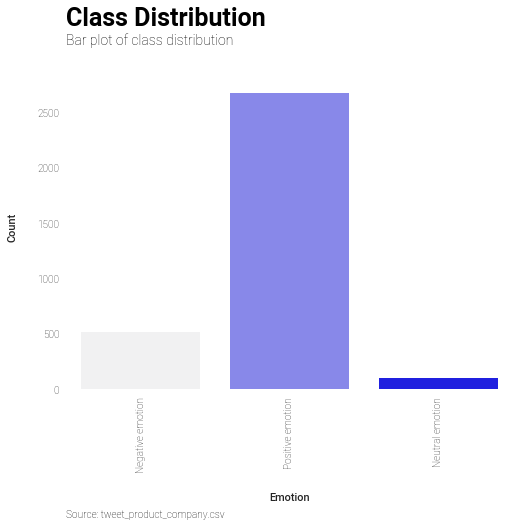

In [23]:

rc = {'figure.figsize':(8,6),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '1',
      'font.family':'Roboto',
      'font.size' : 14,
    'lines.linewidth':4,
     'axes.labelpad': 20,
     'axes.labelweight': 'medium',
     'axes.ymargin': 0.1}
plt.rcParams.update(rc)

ax = sns.countplot(x='label', data=df, palette="light:b")
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Emotion', ylabel='Count')

ax.text(x=0, y=1.1, s='Class Distribution', weight='bold', fontsize=25, color='black', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0, y=1.05, s='''Bar plot of class distribution''', weight='normal', fontsize=14, color='black', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0, y=-0.4, s='Source: tweet_product_company.csv', weight='normal', fontsize=10, color='black', ha='left', va='bottom', transform=ax.transAxes);

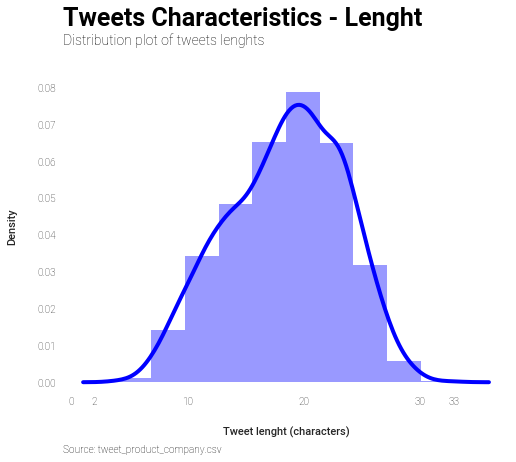

In [42]:
phrase_len = df['tweet_text'].apply(lambda p: len(p.split(' ')))
rc = {'figure.figsize':(8,6),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '1',
      'font.family':'Roboto',
      'font.size' : 14,
    'lines.linewidth':4,
     'axes.labelpad': 20,
     'axes.labelweight': 'medium',
     'axes.ymargin': 0.1}
plt.rcParams.update(rc)

ax = sns.distplot(phrase_len, bins=10, axlabel='Tweet lenght (characters)', color="blue")
ax.set(ylim=(-0.002, None))
# ax.set_xticks(ax.get_xticks()[1:10:1])
ax.set_xticks([0,2, 10,20, 30, 33])

ax.text(x=0, y=1.1, s='Tweets Characteristics - Lenght', weight='bold', fontsize=25, color='black', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0, y=1.05, s='''Distribution plot of tweets lenghts''', weight='normal', fontsize=14, color='black', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0, y=-0.2, s='Source: tweet_product_company.csv', weight='normal', fontsize=10, color='black', ha='left', va='bottom', transform=ax.transAxes);

In [13]:
apple_products = ['iPhone',
 'iPad or iPhone App',
 'iPad',
 'Apple',
 'Other Apple product or service']

google_products = [
 'Google',
 'Android',
 'Android App',
 'Other Google product or service']

df['company'] = '0'
# df_google = df[df['product'].isin(google_products)]

df['company'][df['product'].isin(apple_products)] = 'apple'
df['company'][df['product'].isin(google_products)] = 'google'
df = df[df['company'] != '0']

In [29]:
df

,tweet_text,product,label,company
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,google
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,apple
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,apple
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,google
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,apple


In [26]:
summary = pd.crosstab(df['company'], df['label'], normalize=True)
summary

label,Negative emotion,Neutral emotion,Positive emotion
company,,,
apple,0.117897,0.021878,0.592221
google,0.039806,0.008508,0.219690


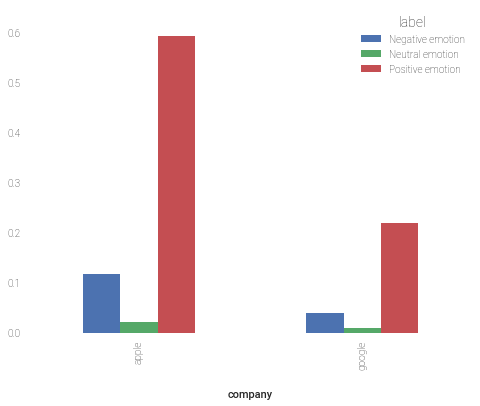

In [27]:
barplt = summary.plot.bar(rot=90)

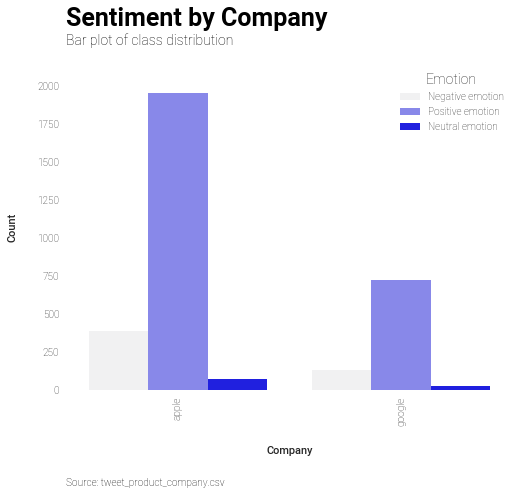

In [30]:
ax = sns.countplot(x='company', data=df, palette="light:b", hue='label')
ax.tick_params(axis='x', rotation=90)
ax.legend(title='Emotion')
ax.set(xlabel='Company', ylabel='Count')

ax.text(x=0, y=1.1, s='Sentiment by Company', weight='bold', fontsize=25, color='black', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0, y=1.05, s='''Bar plot of class distribution''', weight='normal', fontsize=14, color='black', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0, y=-0.3, s='Source: tweet_product_company.csv', weight='normal', fontsize=10, color='black', ha='left', va='bottom', transform=ax.transAxes);

In [36]:
df['bigrams'] = df['tweet_text'].apply(lambda row: list(nltk.ngrams(row.split(), 2)))


In [37]:
df

,tweet_text,product,label,company,bigrams
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,apple,"[(.@wesley83, I), (I, have), (have, a), (a, 3G..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,apple,"[(@jessedee, Know), (Know, about), (about, @fl..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,apple,"[(@swonderlin, Can), (Can, not), (not, wait), ..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,apple,"[(@sxsw, I), (I, hope), (hope, this), (this, y..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,google,"[(@sxtxstate, great), (great, stuff), (stuff, ..."
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,apple,"[(@mention, your), (your, PR), (PR, guy), (guy..."
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,apple,"[(&quot;papyrus...sort, of), (of, like), (like..."
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,google,"[(Diller, says), (says, Google), (Google, TV),..."
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,apple,"[(I've, always), (always, used), (used, Camera..."


### Bag of words

In [17]:
def wordcloud(df):
    
    comment_words = ''
    stopwords = set(STOPWORDS)
    
        # iterate through the csv file
    for val in df:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1500, height = 1500, 
                      max_words=60, 
                      background_color ='white',
                      colormap='cool',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

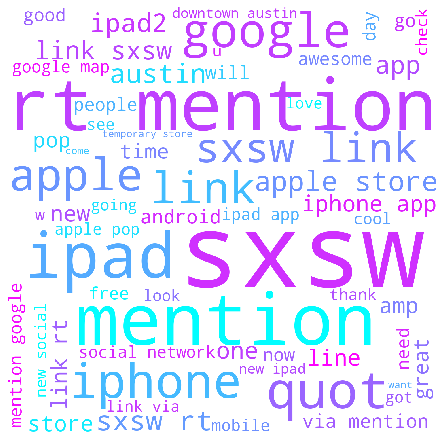

In [18]:
bow = df['tweet_text']
wordcloud(bow)

### References
Generating Word Cloud in Python. GeeksforGeeks

https://www.geeksforgeeks.org/generating-word-cloud-python/

https://machinelearningmastery.com/cost-sensitive-neural-network-for-imbalanced-classification/